In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Instantiate a BigQuery client
client = bigquery.Client(project='logistics-customer-staging')
bq_storage = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\venv_dh\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
# Define the global inputs
entity_id = "FP_TH"
test_keyword = "%price sensitivity1%"
analysis_start_date = "2023-03-15" # 2023-06-01 for TW and 2023-03-15 for TH
order_rank_ceiling = pow(10, 6) # Used to limit the number of vendors to plot CVR3 graphs for in the last step

### DON'T CHANGE THESE INPUTS
df_agg_metrics_group_by_vars = ["entity_id", "test_name", "variant"] # For vendor level, it would be ["entity_id", "test_name", "vendor_id", "variant"]

In [4]:
# Extract order data of these tests
orders_query = """
    WITH test_query AS (
        SELECT DISTINCT test_name
        FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
        WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
    )

    SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,

        -- Location of order
        ent.segment AS region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.segment != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.segment IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.segment NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd -- Contains info on the orders in Pandora countries
    ON TRUE 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date >= DATE("{analysis_start_date_var}")
        AND b.test_name IN (SELECT * FROM test_query) -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment	
    ;
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the orders query
df_orders = client.query(orders_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [5]:
# Calculate the average DF per variant

# First, filter out orders from ASA
df_orders = df_orders[df_orders["variant"] != "Original"]

# Pick the list of functions for each KPI
list_agg_functions = ["mean", "nunique"]
agg_function_selection = {"delivery_fee_local": "mean", "dps_travel_time_fee_local": "mean", "platform_order_code": "nunique"}

# Perform the aggregation
df_agg_metrics = df_orders.\
    groupby(df_agg_metrics_group_by_vars)[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Create a new data frame showing the values for the control group
df_control = df_orders[df_orders["variant"] == "Control"].\
    groupby(df_agg_metrics_group_by_vars[:-1])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Join df_agg_metrics with df_control
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_control, on=df_agg_metrics_group_by_vars[:-1], how="left", suffixes=["", "_control"])

# Change the data types of columns in df_agg_metrics
numerical_cols_df_agg_metrics = ["delivery_fee_local", "dps_travel_time_fee_local", "order_count", "delivery_fee_local_control", "dps_travel_time_fee_local_control", "order_count_control"]
df_agg_metrics[numerical_cols_df_agg_metrics] = df_agg_metrics[numerical_cols_df_agg_metrics].apply(lambda x: pd.to_numeric(x))

# Add new columns showing the elasticity calculations
df_agg_metrics = df_agg_metrics.assign(
    pct_diff_orders=round(df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1, 4),
    pct_diff_tt_fee=round(df_agg_metrics["dps_travel_time_fee_local"] / df_agg_metrics["dps_travel_time_fee_local_control"] - 1, 4),
    pct_diff_df=round(df_agg_metrics["delivery_fee_local"] / df_agg_metrics["delivery_fee_local_control"] - 1, 4),
    elasticity=round((df_agg_metrics["order_count"] / df_agg_metrics["order_count_control"] - 1) / (df_agg_metrics["dps_travel_time_fee_local"]/df_agg_metrics["dps_travel_time_fee_local_control"] - 1), 4)
)

# Display the final data frame
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,10.855280,9.874928,32829,10.85528,9.874928,32829,0.0000,0.0000,0.0000,NaN
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,12.424454,11.789728,32477,10.85528,9.874928,32829,-0.0107,0.1939,0.1446,-0.0553
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,10.754756,10.014298,33012,10.85528,9.874928,32829,0.0056,0.0141,-0.0093,0.3950
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,6.549216,5.524936,36614,10.85528,9.874928,32829,0.1153,-0.4405,-0.3967,-0.2617
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,8.117863,7.096846,33734,10.85528,9.874928,32829,0.0276,-0.2813,-0.2522,-0.0980


In [6]:
# Extract sessions data of these tests
sessions_query = """
  WITH test_query AS (
    SELECT DISTINCT test_name
    FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
  )

  SELECT
    entity_id,
    created_date,
    created_at,
    test_name,
    ga_session_id,
    variant,
    test_zone_id AS zone_id,
    perseus_client_id,
    vendor_code AS vendor_id,
    target_group,
    treatment,
    shop_list_no,
    shop_menu_no,
    checkout_no,
    transaction_no,
  FROM `fulfillment-dwh-production.cl.dps_cvr_ab_tests_treatment`
  WHERE TRUE
    AND created_date >= "{analysis_start_date_var}"
    AND test_name IN (SELECT * FROM test_query) -- Search for relevant tests
    AND vertical_parent_in_test = TRUE -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment
    AND variant != "Original" -- Filter out sessions with variant = "Original"
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the sessions query
df_sessions = client.query(sessions_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [7]:
def count_unique_non_null(x):
    return x.nunique(dropna=True)

# Perform the aggregation
df_agg_cvr = df_sessions.\
    groupby(df_agg_metrics_group_by_vars)[["ga_session_id", "shop_list_no", "shop_menu_no", "checkout_no", "transaction_no"]].\
    agg(count_unique_non_null).\
    reset_index()

# Add new columns calculating CVR
df_agg_cvr["cvr"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["ga_session_id"], 4)
df_agg_cvr["cvr3"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["shop_menu_no"], 4)

# Create a new data frame showing the values for the control group
df_agg_cvr = pd.merge(
    left=df_agg_cvr,
    right=df_agg_cvr[df_agg_cvr["variant"] == "Control"][df_agg_metrics_group_by_vars[:-1] + ["cvr", "cvr3"]],
    on=df_agg_metrics_group_by_vars[:-1],
    how="left",
    suffixes=["", "_control"]
)

# Calculate the CVR % difference between variation and control
df_agg_cvr = df_agg_cvr.assign(
    pct_diff_cvr=round(df_agg_cvr["cvr"] / df_agg_cvr["cvr_control"] - 1, 4),
    pct_diff_cvr3=round(df_agg_cvr["cvr3"] / df_agg_cvr["cvr3_control"] - 1, 4),
)
df_agg_cvr.head()

,entity_id,test_name,variant,ga_session_id,shop_list_no,shop_menu_no,checkout_no,transaction_no,cvr,cvr3,cvr_control,cvr3_control,pct_diff_cvr,pct_diff_cvr3
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,59683,31654,55839,30306,28454,0.4768,0.5096,0.4768,0.5096,0.0000,0.0000
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,60503,31865,56451,30050,27999,0.4628,0.4960,0.4768,0.5096,-0.0294,-0.0267
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,60595,32519,56544,30252,28452,0.4695,0.5032,0.4768,0.5096,-0.0153,-0.0126
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,65442,35480,61086,33484,31507,0.4814,0.5158,0.4768,0.5096,0.0096,0.0122
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,60726,33308,56772,31166,29296,0.4824,0.5160,0.4768,0.5096,0.0117,0.0126


In [8]:
# Join df_agg_cvr to df_agg_metrics
df_agg_metrics = pd.merge(
    left=df_agg_metrics,
    right=df_agg_cvr[df_agg_metrics_group_by_vars + ["cvr", "pct_diff_cvr", "cvr3", "pct_diff_cvr3"]],
    on=df_agg_metrics_group_by_vars,
    how="left"
)
df_agg_metrics.head()

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity,cvr,pct_diff_cvr,cvr3,pct_diff_cvr3
0,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Control,10.855280,9.874928,32829,10.85528,9.874928,32829,0.0000,0.0000,0.0000,NaN,0.4768,0.0000,0.5096,0.0000
1,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation1,12.424454,11.789728,32477,10.85528,9.874928,32829,-0.0107,0.1939,0.1446,-0.0553,0.4628,-0.0294,0.4960,-0.0267
2,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation2,10.754756,10.014298,33012,10.85528,9.874928,32829,0.0056,0.0141,-0.0093,0.3950,0.4695,-0.0153,0.5032,-0.0126
3,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation3,6.549216,5.524936,36614,10.85528,9.874928,32829,0.1153,-0.4405,-0.3967,-0.2617,0.4814,0.0096,0.5158,0.0122
4,FP_TH,TH_20230313_Chantaburi_price sensitivity1,Variation4,8.117863,7.096846,33734,10.85528,9.874928,32829,0.0276,-0.2813,-0.2522,-0.0980,0.4824,0.0117,0.5160,0.0126


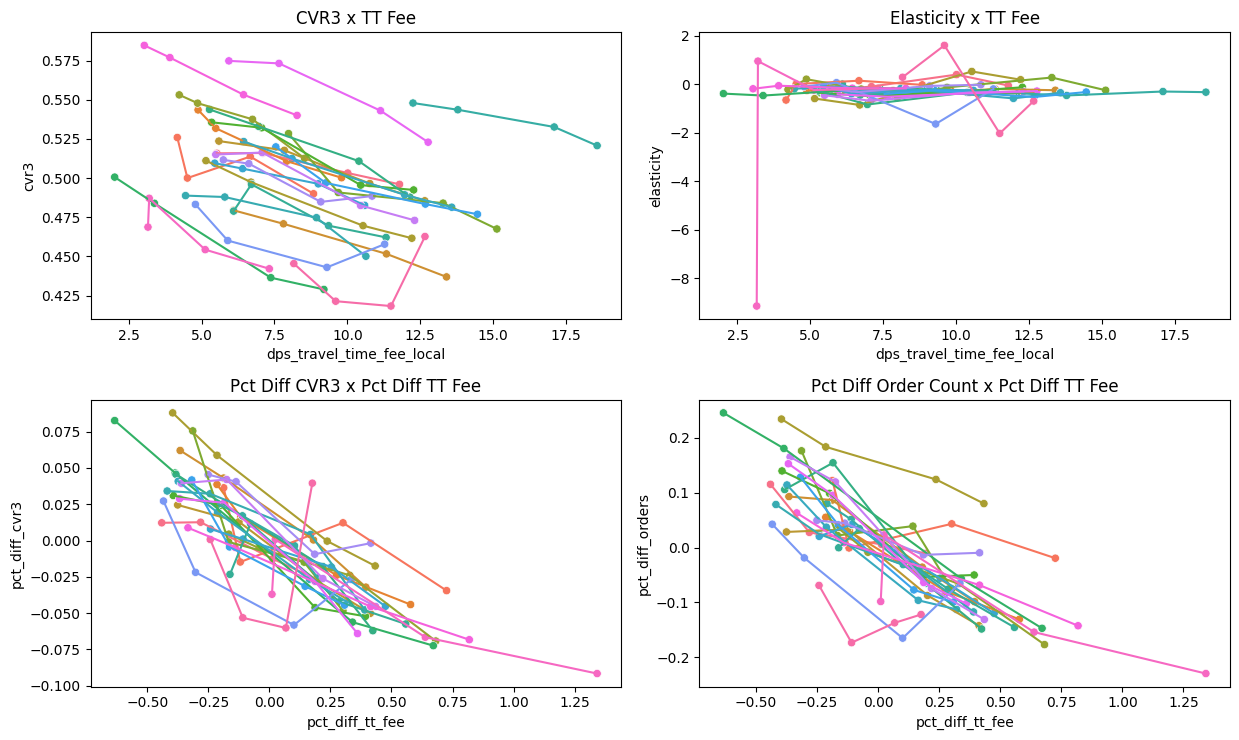

In [9]:
# Create the data frame for plotting
# Include this condition if you wish to exclude the outlier tests --> ~(df_agg_metrics["test_name"].isin(["20230601_TW_R_Elasticity_Penghu", "20230601_TW_R_Elasticity_Kinmen"]))
df_plot = df_agg_metrics[(df_agg_metrics["variant"] != "Control")]\
    [df_agg_metrics_group_by_vars + ["pct_diff_tt_fee", "pct_diff_orders", "pct_diff_cvr", "pct_diff_cvr3", "elasticity", "dps_travel_time_fee_local", "order_count", "cvr", "cvr3"]]

# Create a total_order_rank column in case you want to plot the CVR3 graphs for a subset of vendors
df_plot["total_orders"] = df_plot.groupby(df_agg_metrics_group_by_vars[:-1])["order_count"].transform('sum')
df_plot = df_plot.sort_values(["entity_id", "test_name", "total_orders"], ascending=[True, True, False])
df_plot['rank_total_orders'] = df_plot['total_orders'].rank(ascending=False, method='dense')
df_plot = df_plot[df_plot["rank_total_orders"] <= order_rank_ceiling]

# Create some EDA plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 7.5))

# 1st chart: TT fee x CVR
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue="test_name", ax=axes[0,0])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="cvr3", hue="test_name", ax=axes[0,0])
axes[0,0].set_title("CVR3 x TT Fee")

# 2nd chart: TT fee x elasticity
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
axes[0,1].set_title("Elasticity x TT Fee")

# 3rd chart: Pct Diff TT fee x Pct Diff CVR
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue="test_name", ax=axes[1,0])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr3", hue="test_name", ax=axes[1,0])
axes[1,0].set_title("Pct Diff CVR3 x Pct Diff TT Fee")

# 4th chart: pct_diff_tt_fee x pct_diff_orders
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[1,1])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[1,1])
axes[1,1].set_title("Pct Diff Order Count x Pct Diff TT Fee")

# Remove the legends
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()

# Right layout
plt.tight_layout()